In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

### Buck Structure and Inference

In [3]:
# import the modules and functions
import torch
from pann_net import PANN, EulerCell_Buck
from pann_utils import evaluate


# define circuit parameters and network variables
L, Co, Ro = 50e-6, 1000e-6, 3
Ts = 1/20e3
Tslen = 100
dt = Ts/Tslen

buck_Euler_cell = torch.jit.script(EulerCell_Buck(dt, L, Co, Ro)) # define the Euler cell for DAB
pann_buck = torch.jit.script(PANN(buck_Euler_cell)) # define the PANN for DAB
print(pann_buck)

RecursiveScriptModule(
  original_name=PANN
  (cell): RecursiveScriptModule(original_name=EulerCell_Buck)
)


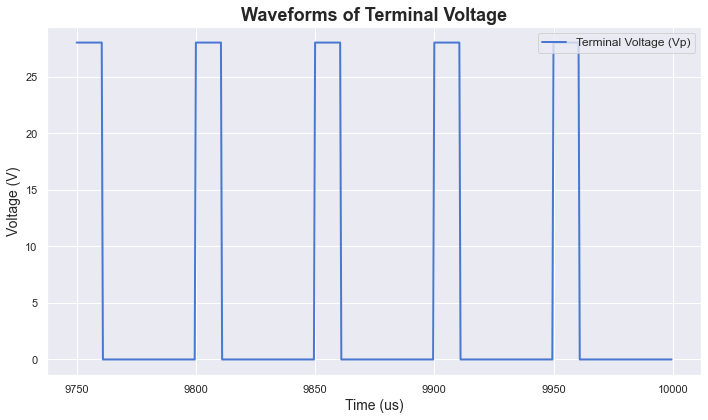

In [4]:
import numpy as np
from pann_utils import duty_cycle_mod, get_inputs


Vin, Vref = 28, 6
D0 = Vref/Vin
Tsim = 200*Ts # simulation time, considering 10 times of switching periods
# generate terminal voltage waveform vp given one set of modulation parameters
vp = duty_cycle_mod(D0, Vin, dt, Tsim, Ts)
t = np.arange(0, len(vp)*dt, dt)




#################################################################################
# plot the ac voltage waveforms vp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")  # Use a dark grid background for contrast
# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot the waveforms with Seaborn style enhancements
plt.plot(t[-5*Tslen:]*1e6, vp[-5*Tslen:], label='Terminal Voltage (Vp)', 
         color=sns.color_palette("muted")[0], linestyle='-', linewidth=2)

# Add a title and labels
plt.title('Waveforms of Terminal Voltage', fontsize=18, weight='bold')
plt.xlabel('Time (us)', fontsize=14)
plt.ylabel('Voltage (V)', fontsize=14)

# Add a grid for better readability (already part of Seaborn darkgrid)
plt.grid(True)
# Add a legend to describe the waveforms
plt.legend(loc='upper right', fontsize=12)
# Show the plot
plt.tight_layout()  # Adjust layout for better fit
plt.show()

In [5]:
# construct inputs tensor in numpy
inputs = vp[None, :, None]
print(inputs.shape, type(inputs)) # inputs should be of shape (bs x seq_len x inp_dim)
# convert to torch FloatTensor
inputs = torch.FloatTensor(inputs)
print(inputs.shape, type(inputs))


# initialize the state variable
state_dim = 2
state0 = torch.zeros((inputs.shape[0], 1, state_dim)) 
# use PANN to infer the state variable iL
pann_buck.eval()
with torch.no_grad():
    # don't capture the computational graph, as this is not training
    states = pann_buck(inputs, state0)
print(states.shape, type(states))

(1, 20000, 1) <class 'numpy.ndarray'>
torch.Size([1, 20000, 1]) <class 'torch.Tensor'>
torch.Size([1, 20000, 2]) <class 'torch.Tensor'>


<IPython.core.display.Javascript object>


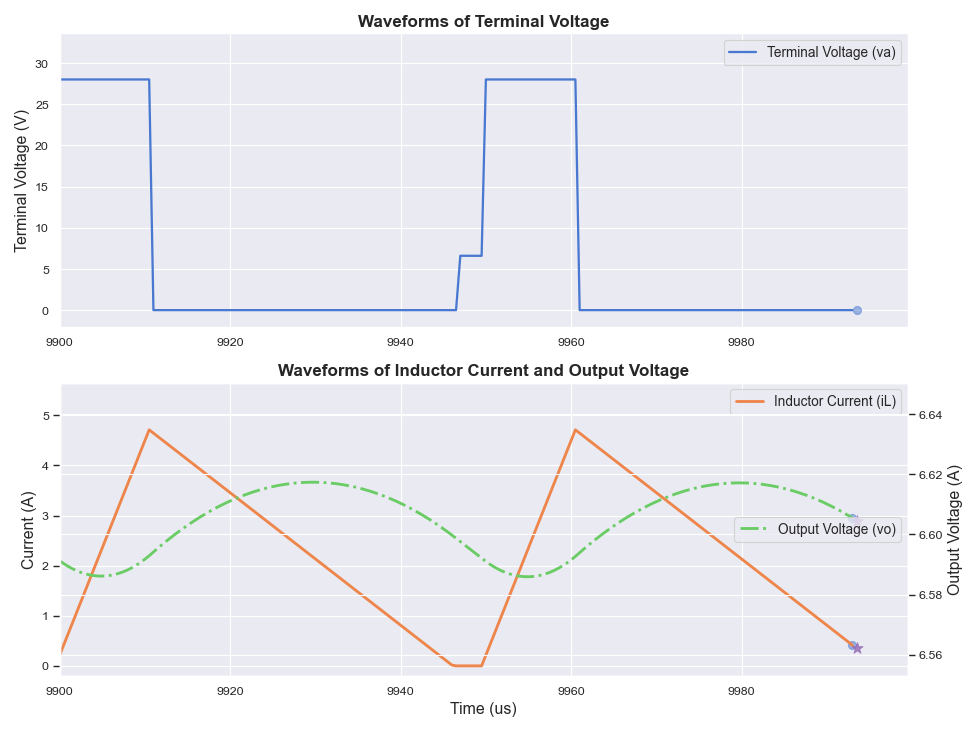

In [6]:
#################################################################################
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook
# if use google colab
# %matplotlib widget


if len(inputs.shape) == 3:
    t = t[-2*Tslen:]*1e6
    inputs = inputs[0, -2*Tslen:]
    states = states[0, -2*Tslen:]
# Example data for vp and vs
# inputs: size (seqlen x inp_dim)
# states: size (seqlen x state_dim)
sns.set(style="darkgrid")  # Use a dark grid background for contrast

t, inputs, states = np.array(t), np.array(inputs), np.array(states)
vp, iL, vo = inputs[:, 0], states[:, 0], states[:, 1]
# Create figure and subplots (two subplots: one for vp, one for vs)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
ax22 = ax2.twinx() # Create a second axes that shares the same x-axis

# Set limits for both plots
ax1.set_xlim(t.min(), t.max())
ax1.set_ylim(-2, inputs.max()*1.2)
ax2.set_xlim(t.min(), t.max())
ax2.set_ylim(-0.2, states[:, 0].max()*1.2)
ax22.set_ylim(states[:, 1].min()*0.995, states[:, 1].max()*1.005)
# Labels and titles
ax1.set_title('Waveforms of Terminal Voltage', fontsize=15, weight='bold')
ax2.set_title('Waveforms of Inductor Current and Output Voltage', fontsize=15, weight='bold')
# ax1.set_xlabel('Time (us)', fontsize=14)
ax1.set_ylabel('Terminal Voltage (V)', fontsize=14)
ax2.set_xlabel('Time (us)', fontsize=14)
ax2.set_ylabel('Current (A)', fontsize=14)
ax22.set_ylabel('Output Voltage (A)', fontsize=14)

# Initialize empty lines for both plots
line1_1, = ax1.plot([], [], lw=2, label='Terminal Voltage (va)', 
                    color=sns.color_palette("muted")[0], linestyle='-')
line2_1, = ax2.plot([], [], lw=2.5, label='Inductor Current (iL)', 
                    color=sns.color_palette("muted")[1], linestyle='-')
line2_2, = ax22.plot([], [], lw=2.5, label='Output Voltage (vo)', 
                    color=sns.color_palette("muted")[2], linestyle='-.')
dot1_1 = ax1.scatter([], [], edgecolor=sns.color_palette("muted")[0], alpha=0.5,
                     s=50, color=sns.color_palette("muted")[0], marker="o")
dot2_1 = ax2.scatter([], [], edgecolor=sns.color_palette("muted")[0], alpha=0.5,
                     s=50, color=sns.color_palette("muted")[0], marker="o")
dot2_2 = ax22.scatter([], [], edgecolor=sns.color_palette("muted")[0], alpha=0.5,
                     s=50, color=sns.color_palette("muted")[0], marker="o")
dot2_3 = ax2.scatter([], [], edgecolor=sns.color_palette("muted")[4], alpha=0.8,
                     s=100, color=sns.color_palette("muted")[4], marker="*")
dot2_4 = ax22.scatter([], [], edgecolor=sns.color_palette("muted")[4], alpha=0.8,
                     s=100, color=sns.color_palette("muted")[4], marker="*")

# Add grids and legends
ax1.grid(True)
ax2.grid(True)
# ax22.grid(False)
ax1.legend(loc='upper right', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)
ax22.legend(loc='center right', fontsize=12)


# Initialize the animation
def init():
    line1_1.set_data([], [])
    line2_1.set_data([], [])
    line2_2.set_data([], [])
    dot1_1.set_offsets(np.empty((0, 2)))  # Initialize empty scatter for subplot 1
    dot2_1.set_offsets(np.empty((0, 2)))  # Initialize empty scatter for subplot 2
    dot2_2.set_offsets(np.empty((0, 2)))  # Initialize empty scatter for subplot 2
    dot2_3.set_offsets(np.empty((0, 2)))  # Initialize empty scatter for subplot 2
    dot2_4.set_offsets(np.empty((0, 2)))  # Initialize empty scatter for subplot 2
    return line1_1, line2_1, line2_2, dot1_1, dot2_1, dot2_2, dot2_3, dot2_4

# Update the plots
def update(frame):
    line1_1.set_data(t[:frame+1], vp[:frame+1])  # Update vp plot progressively
    line2_1.set_data(t[:frame+1], iL[:frame+1])  # Update vs plot progressively
    line2_2.set_data(t[:frame+1], vo[:frame+1])  # Update iL plot progressively
    dot1_1.set_offsets(np.c_[t[frame+1], vp[frame+1]])
    dot2_1.set_offsets(np.c_[t[frame], iL[frame]])
    dot2_2.set_offsets(np.c_[t[frame], vo[frame]])
    dot2_3.set_offsets(np.c_[t[frame+1], iL[frame+1]])
    dot2_4.set_offsets(np.c_[t[frame+1], vo[frame+1]])

    return line1_1, line2_1, line2_2, dot1_1, dot2_1, dot2_2, dot2_3, dot2_4


# Create the animation
ani = FuncAnimation(fig, update, frames=inputs.shape[0]-1, 
                    init_func=init, blit=False, interval=5)

# save as GIF file
# ani.save('Buck-inference.gif', writer='pillow')

# Show the plot
plt.tight_layout()  # Adjust layout for better fit
# Display the animation in Jupyter
plt.show()